# Find  A Cost Of An Apartment


**Identity Number:** 313190811  
**Name:** Igal Khalfin  
**Identity Number:** 313197378  
**Name:** Adir Nisim  

## Research Question
#### What is the price of an apartment based on historical deals made by people and were assigned by reliable source?

## Objective 
* **Scrapping data** from reliable source, contains realestate data relevent for **price prediction**.  
* Preform **"Data Cleaning"** on the extracted data.  
* Finding **correlation** betweeen diffrent variables and data distribution
* **Visualize** insights taken from our analysis   
* **Understand realestate prices among latest years and finding the best model to predict them**
* Appling **machine learning** models and prediction.


## Import Modules (Packages)


In [13]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import time
import os
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    #roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, #plot_roc_curve
)

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures


# Website Crawling & Scraping  
With a lack of dedicated API, we found a website containing all of the deals in Israel while filtered by input parameters.


### Methods
* Selenium - The target website is dynamic, forces using this method. 
* Pandas  - Storing and manipulating data. 

### Sources 
* https://www.nadlan.gov.il/


In [ ]:
crawling_enabled = True
if crawling_enabled:
    # Global variables
    autoScroll = 1  # Flag for autoscroll in NadlanGov.
    waitTime = 10  # Waiting time for loading the search value transactions.
    slow_wait_time = 5
    scrollWaitingTime = 10
    topHeight = 55*1000000
    # Maximum value for loading 50K values in a table of NadlanGov 55 inches per line.
    city = "ראשון לציון"
    en_city = "Rishon_le-zion"
    pool_size = 1
    scroll_down_limit = 1

    # For multithreading CSV files
    file_list = [
                   f'./Data/{en_city}/filter_by_1.csv',
                   f'./Data/{en_city}/filter_by_2.csv',
                   f'./Data/{en_city}/filter_by_3.csv',
                   f'./Data/{en_city}/filter_by_4.csv',
                   f'./Data/{en_city}/filter_by_5.csv'
               ]


    # Getting the topics (Keys) for dict.
    def get_topics(web_driver: webdriver, headers: dict):
        header_elements = web_driver.find_element(By.XPATH, "//*[contains(@class, 'myTable')]/div[2]/div[5]")
        # Columns titles each of Row as a Key for dictionary.
        for header in header_elements.find_elements(by=By.TAG_NAME, value='button'):
            if header.get_attribute('aria-label') != '':
                headers[header.get_attribute('aria-label')] = []


    # Scrolling down the table
    def scroll_down_table(web_driver: webdriver, auto: int):
        scroll_number = 0
        # Scroll down for loading more data in table
        if auto:
            check_height = web_driver.execute_script("return document.body.scrollHeight;")
            while auto:
                scroll_number += 1
                web_driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                loader = web_driver.find_element(By.CLASS_NAME, "loading")
                while not loader.get_attribute('class').__contains__('ng-hide'):
                    continue
                height = web_driver.execute_script("return document.body.scrollHeight;")
                print("scroll_down_limit", scroll_down_limit)
                print("scroll_number", scroll_number)
                if height == check_height or height > topHeight or scroll_number > scroll_down_limit:
                    auto = 0
                    break
                check_height = height


    # Getting the data from table
    def get_data_from_table(web_driver: webdriver, headers: dict):
        # Lists of values
        prices_of_history_dates = []
        dates_of_history = []
        my_table = web_driver.find_element(By.XPATH, "//*[contains(@class, 'tableBody')]")
        # rows data, each value of data by topic will be insert for the belong list in the dictionary.
        for row in my_table.find_elements(by=By.CLASS_NAME, value='rbutton'):
            web_driver.execute_script(f"arguments[0].scrollIntoView(true);", row)
            web_driver.execute_script(f"window.scrollBy(0, -500);")
            for i, field in enumerate(row.find_elements(by=By.CLASS_NAME, value='tableCol')):
                elements = field.find_elements(by=By.TAG_NAME, value='div')
                if field.tag_name == 'div' and len(elements) > 0:
                    value = elements[0].get_attribute('title')
                    if value == '':
                        value = 'NaN' # if value is empty NaN will be insert.
                    if i > 8:
                        break
                    headers[list(headers.keys())[i]].append(value)
                else:
                    headers[list(headers.keys())[i]].append('NaN')
            # Getting the Addition Data of history
            # Clicking the line
            row.find_elements(By.CLASS_NAME, 'tableCol')[0].find_element(By.TAG_NAME, 'div').click()
            # Getting the Elements
            time.sleep(1)
            # Getting Data from inside button of history dates and prices
            history_data = my_table.find_element(by=By.CLASS_NAME, value="resultOptions")
            history_prices = history_data.find_elements(by=By.CLASS_NAME, value="historyPrice")
            history_dates = history_data.find_elements(by=By.CLASS_NAME, value="historyDate")
            history_records = []
            # Adding Values into lists
            for field_of_dates in history_dates:
                record = {'history_date': field_of_dates.text}
                history_records.append(record)
            for i, field_of_price in enumerate(history_prices):
                history_records[i]['history_price'] = field_of_price.text
            if history_records:
                for history_record in history_records:
                    for column in headers:
                        headers[column].append(headers[column][-1])
                    headers['סכום'][-1] = history_record['history_price']
                    headers['יום מכירה'][-1] = history_record['history_date']

            # clearing list for next time
            dates_of_history.clear()
            prices_of_history_dates.clear()

            # click button again
            row.find_elements(By.CLASS_NAME, 'tableCol')[0].find_element(By.TAG_NAME, 'div').click()


    bedroom_filtering_range = range(pool_size, pool_size + 1)
    for bedroom_filter in bedroom_filtering_range:
        # Open webdriver for multi threading
        # Web crawling start.
        # declaring of chromedriver l
        # ocation
        ser = Service(os.path.realpath(f"./webdriver/chromedriver.exe"))
        driver = webdriver.Chrome(service=ser)

        # Open Page by URL
        url = 'https://www.nadlan.gov.il/'
        driver.get(url)

        # Search box of website
        search_box = driver.find_element(By.ID, "SearchString")
        search_box.send_keys(city)  # insert input into the textbox

        # Search Button
        search_button = driver.find_element(By.ID, "submitSearchBtn")
        search_button.click()

        time.sleep(1)

        # Get new search link
        loader = driver.find_element(By.CLASS_NAME, "loading")
        while not loader.get_attribute('class').__contains__('ng-hide'):
            continue

        # Dictionary { Key: topic, Value: List }
        topics = {}
        # Get new search link
        time.sleep(1)
        # Getting keys for dic : topics
        get_topics(driver, topics)

        # selection by room filter
        div_button = driver.find_elements(By.CLASS_NAME, "btnsWrapper")[1]
        filter_bedroom_selection = div_button.find_element(By.TAG_NAME, "button")
        filter_bedroom_selection.click()
        selection = \
            div_button.find_element(By.CLASS_NAME, "roomsFillter").find_elements(By.TAG_NAME, "button")[bedroom_filter]
        selection.click()

        time.sleep(1)

        # Time sleep
        loader = driver.find_element(By.CLASS_NAME, "loading")
        while not loader.get_attribute('class').__contains__('ng-hide'):
            continue

        # scrolling down the table
        scroll_down_table(driver, autoScroll)
        # table data into the Dic

        # Time sleep
        time.sleep(waitTime)
        # Getting data from table
        get_data_from_table(driver, topics)

        # create data frame
        df = pd.DataFrame(data=topics)
        # create CSV File
        if not os.path.isdir(f"./CSV files/{en_city}"):
            os.makedirs(os.path.realpath(f"./CSV files/{en_city}"))
        df.to_csv(os.path.realpath(f"./CSV files/{en_city}/filter_by_{bedroom_filter}.csv"),encoding='utf-8-sig')


<h1><ins>Data Handling </ins></h1>




## Data Migration
* Merge **all** of CSV files filterd by room number into **one DataFrame**.
* **Spliting** sector, block, property and date into **numeric columns** (Vecotrize Data).
* **Convert** Strings into int parameters (price topic).
* Changing floor to number.


In [2]:
en_city = "Rishon_le-zion"

In [3]:
# unite all csv files into one.
dataframe = pd.concat(
    map(pd.read_csv, [f'./CSV files/{en_city}/filter_by_5.csv', f'./CSV files/{en_city}/filter_by_4.csv',
                      f'./CSV files/{en_city}/filter_by_3.csv', f'./CSV files/{en_city}/filter_by_2.csv'
                      ,f'./CSV files/{en_city}/filter_by_1.csv']), ignore_index=True)
dataframe=dataframe.dropna(axis=0)
# drop last column
dataframe.pop('מגמת שינוי')

# seprate colum into few colums to create vectors.
new = dataframe["גוש חלקה - תת חלקה"].str.split("-", n = 2, expand = True)
split_date = dataframe["יום מכירה"].str.split(".", n = 2, expand = True)
dataframe["גוש"] = new[0]
dataframe["חלקה"] = new[1]
dataframe["נכס"] = new[2]
dataframe["יום"] = split_date[0]
dataframe["חודש"] = split_date[1]
dataframe["שנה"] = split_date[2]
#Delete Coloums after split.
del dataframe["גוש חלקה - תת חלקה"]
del dataframe["יום מכירה"]
del dataframe["Unnamed: 0"]
# change to column to integer.
dataframe['סכום'] = dataframe['סכום'].str.replace(',','')
dataframe['סכום'] = dataframe['סכום'].astype(int)

# changing the floor to number
dataframe_floor = pd.read_csv("./CSV files/floor.csv")
for key, value in dataframe_floor.iterrows():
    dataframe.replace(value["floor"], value["floornumber"], inplace=True)

# Changing topic names.
dataframe = dataframe.rename(columns = {"סוג נכס":"propery_type" , "חדרים":"rooms" , "קומה" :"floor",'מ"ר':"square_foot","סכום":"price","גוש":"sector","חלקה":"block","נכס":"property","יום":"day","חודש":"month", "שנה":"year", "כתובת": "address"})
# Changing senteces to number for vector compatabilty 
dataframe.replace("דירה בבית קומות", "1", inplace=True) # 1
dataframe.replace("קוטג' דו משפחתי", "2", inplace=True) # 2
dataframe.replace("דירת גג", "3", inplace=True) # 3
dataframe.replace("דירת גן", "4", inplace=True) # 1
dataframe.replace("חנות", "5", inplace=True) # 1
dataframe.replace("קוטג' חד משפחתי", "6", inplace=True) # 2
dataframe.replace("קוטג' טורי", "7", inplace=True) # 2
dataframe.to_csv(os.path.realpath(f"./CSV files/{en_city}/First.csv"),encoding='utf-8-sig')
dataframe


address propery_type  rooms  floor  square_foot    price sector  \
1       חיל האויר 1            1    5.0     15       111.85  3400000   2717   
2       חיל האויר 1            1    5.0     15       111.85  2570000   2717   
3       חיל האויר 1            1    5.0     15       111.85  1450000   2717   
4          המלחים 2            1    5.0      2       119.73  2830000   4746   
5          המלחים 2            1    5.0      2       119.73  1730000   4746   
...             ...          ...    ...    ...          ...      ...    ...   
39042  ההתיישבות 53            1    1.0      3       106.41  1137000   6286   
39045  ההתיישבות 53            1    1.0      8       155.72  1680000   6286   
39046  ההתיישבות 53            1    1.0      8       155.72  1622000   6286   
39047  ההתיישבות 53            1    1.0      8       155.93  1740000   6286   
39048  ההתיישבות 53            1    1.0      8       155.93  1622000   6286   

      block property day month  year  
1        36       56  14    04  2022  
2        36       56  19    11  2019  
3        36       56  23    10  2008  
4         8        7  13    04  2022  
5         8        7  06    11  2013  
...     ...      ...  ..   ...   ...  
39042   324        7  15    07  2009  
39045   324       29  24    03  2010  
39046   324       29  03    08  2009  
39047   324       30  24    03  2010  
39048   324       30  23    07  2009  

[20747 rows x 12 columns]

<h1><ins>Vector Refactoring </ins></h1> 

Using Google Geo-Coding api: https://developers.google.com/maps/documentation/geocoding/overview  
We need to convert address labels to numerical values presented as a postion constructed from latitude & longitude 


In [ ]:
enable_geocoding = False

In [ ]:
if enable_geocoding :
    #Creating a DataFrame, that will hold all uniqe addresses, to reduce Google Maps api requests.
    data_frame_of_address = pd.DataFrame()
    data_frame_of_address["address"] = dataframe["address"].drop_duplicates()
    data_frame_of_address.head()
    data_frame_of_address = pd.DataFrame()
    data_frame_of_address["address"] = dataframe["address"].drop_duplicates()
    print(data_frame_of_address)
    


In [ ]:
if enable_geocoding :
    base_url = "https://maps.googleapis.com/maps/api/geocode/json?"
     #for loop to change address to cordinate by GeoCoding API. 
    for key , value in data_frame_of_address.iterrows():
        value["address"]
        ad_parmater= value["address"]
        params = {
         'key': "API_KEY",
         'address' : f"{ad_parmater} ראשון לציון"
        }
        response = requests.get(base_url,params=params)
        cordinates_data = response.json()
        coordinates = cordinates_data['results'][0]['geometry']['location']
        # Spliting Data for 2 colums.
        lat = coordinates['lat']
        lng = coordinates['lng']
        dataframe.replace(ad_parmater,f'{lat},{lng}', inplace=True)
        i += 1
        
    new_data_location = dataframe["address"].str.split(",", n = 1, expand = True)
    dataframe["lat"]=new_data_location[0]
    dataframe["lng"]=new_data_location[1]
    # Deleting Adress Topics after chainging to corinets
    del dataframe["address"]
    print(dataframe.head())
    # Genarate Converted-Data CSV.
    dataframe.to_csv("LastCSV.csv",index=False, encoding='utf-8-sig')

<h1><ins>Data Cleaning</ins></h1>  

#### Using describe command to detect outliers.

* Removing Outliers  
* Remove Rows with missing values.  

In [6]:
last_ready_csv = pd.read_csv("LastCSV.csv",index_col=0)

In [15]:
plt.figure(figsize=(60,20), dpi = 800)
sns.catplot(data=last_ready_csv, kind='box', col='year', x='rooms', y='price', hue='rooms', sharey=False, height=30)

<Figure size 48000x16000 with 0 Axes>

In [5]:
last_ready_csv.describe()

rooms         floor   square_foot         price        sector  \
count  20747.000000  20747.000000  20747.000000  2.074700e+04  20747.000000   
mean       3.663855      3.466622     84.341056  1.271865e+06   4661.703861   
std        0.918619      2.840668     31.062417  6.547570e+05   1069.049340   
min        1.000000      0.000000     21.500000  6.700000e+04   2704.000000   
25%        3.000000      2.000000     64.380000  7.670000e+05   3929.000000   
50%        4.000000      3.000000     78.700000  1.190000e+06   3945.000000   
75%        4.000000      4.000000     97.000000  1.610000e+06   5182.000000   
max        9.000000     24.000000    499.000000  6.900000e+06   7375.000000   

              block      property           day         month          year  \
count  20747.000000  20747.000000  20747.000000  20747.000000  20747.000000   
mean     277.092303     23.648046     15.715284      6.438184   2011.268858   
std      292.093269     45.069805      8.824737      3.478276      6.636665   
min        2.000000      0.000000      1.000000      1.000000   1998.000000   
25%       46.000000      6.000000      8.000000      3.000000   2007.000000   
50%      151.000000     12.000000     16.000000      6.000000   2012.000000   
75%      442.000000     25.000000     23.000000      9.000000   2017.000000   
max     1365.000000    639.000000     31.000000     12.000000   2022.000000   

                lat           lng  
count  20747.000000  20747.000000  
mean      31.969913     34.793762  
std        0.009976      0.019148  
min       31.944642     34.735100  
25%       31.963468     34.780686  
50%       31.968635     34.798027  
75%       31.973548     34.808407  
max       32.068392     34.857651

In [6]:
# Removing outliers.

vector_csv = pd.read_csv("LastCSV.csv")

for i in range(1,6):
    for j in range(1998,2023):
        one_room_df_2022 = vector_csv[(vector_csv['year'] == j) & (vector_csv['rooms'] == i)]
        if one_room_df_2022.count()['rooms'] > 0:
            Q1 = np.percentile(one_room_df_2022['price'], 25)
            Q3 = np.percentile(one_room_df_2022['price'], 75)
            IQR = Q3 - Q1

            outlier_rows = one_room_df_2022[(one_room_df_2022['price'] < Q1 - 1.5 * IQR) | (one_room_df_2022['price'] > Q3 + 1.5 * IQR)].index
            len(outlier_rows)
            vector_csv.drop(outlier_rows, axis=0, inplace=True)
            vector_csv.count()

last_ready_csv = vector_csv
fast_api_csv = last_ready_csv.drop(["sector", "block", "property"],axis = 1)
fast_api_csv.to_csv("fast_api_csv.csv",index=False, encoding='utf-8-sig')

In [7]:
last_ready_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20065 entries, 0 to 20746
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   propery_type  20065 non-null  int64  
 1   rooms         20065 non-null  float64
 2   floor         20065 non-null  int64  
 3   square_foot   20065 non-null  float64
 4   price         20065 non-null  int64  
 5   sector        20065 non-null  int64  
 6   block         20065 non-null  int64  
 7   property      20065 non-null  int64  
 8   day           20065 non-null  int64  
 9   month         20065 non-null  int64  
 10  year          20065 non-null  int64  
 11  lat           20065 non-null  float64
 12  lng           20065 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 2.1 MB


<h1> <u> Visualization </u> </h1>




## Correlation Between Fields

We want to  find out correlation between all of our numeric variables.  
We will use heatmap plot that will demonstrate which column has higher correlation rate:

<AxesSubplot:>

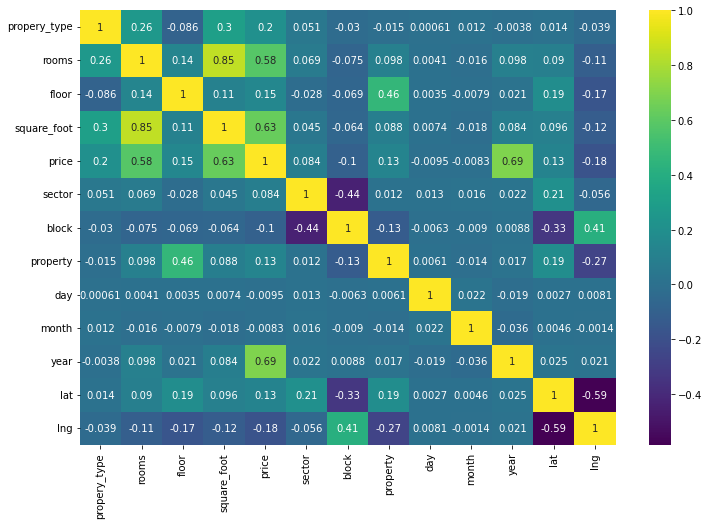

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(last_ready_csv.corr(), annot=True, cmap='viridis')

In [143]:
x = last_ready_csv.drop('price', axis=1)
y = last_ready_csv.price

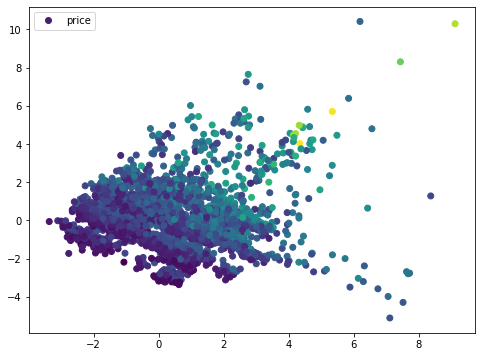

In [146]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
x_train, x_test , y_train , y_test = train_test_split(x,y,test_size=0.2,random_state = 0)
x_data = x_test
y_data = y_test
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
plt.figure(figsize=(8,6))
Xt = pipe.fit_transform(x_data)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_data)
plt.legend(handles=plot.legend_elements()[0], labels=list(["price"]))
plt.show()

## Les's see our data distribution


### As you can see we didnt found correlation between this colums:

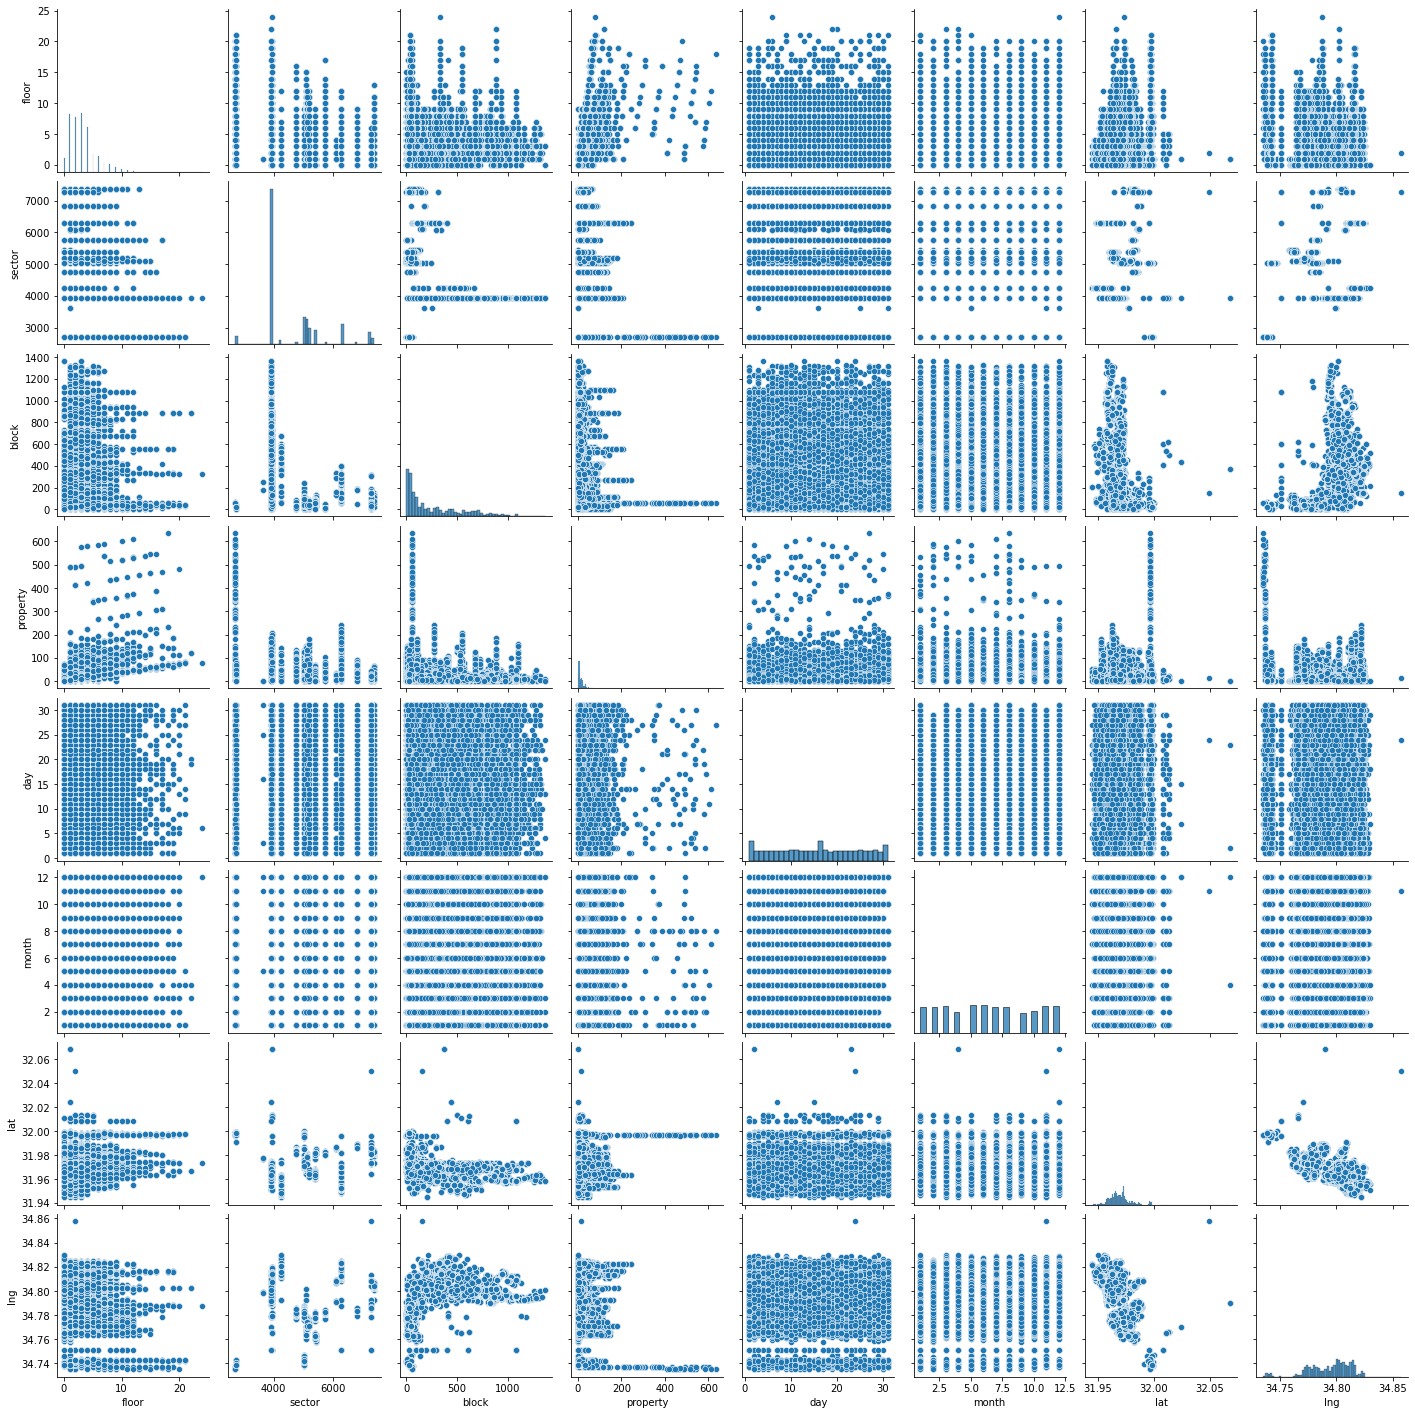

In [11]:
sns.pairplot(last_ready_csv[["floor","sector","block","property","day","month","lat","lng"]])


### While we saw some correlation between price,squarefoot and rooms:


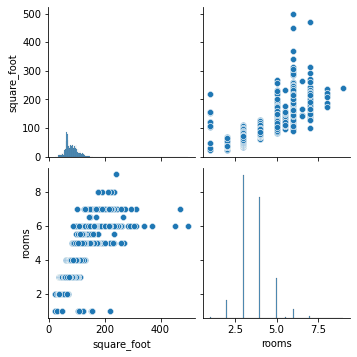

In [12]:
sns.pairplot(last_ready_csv[['square_foot', 'rooms']])

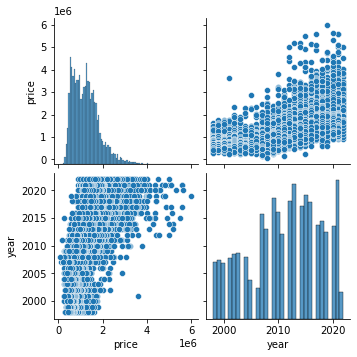

In [13]:
sns.pairplot(last_ready_csv[['price', 'year']])

In [14]:
new_df_scatter = last_ready_csv["month"]
df_count = new_df_scatter.value_counts()
List_count = df_count.values.tolist()
new_df_scatter = new_df_scatter.drop_duplicates()
new_df_scatter.reset_index(drop=True)
new_df_scatter = new_df_scatter.sort_values()



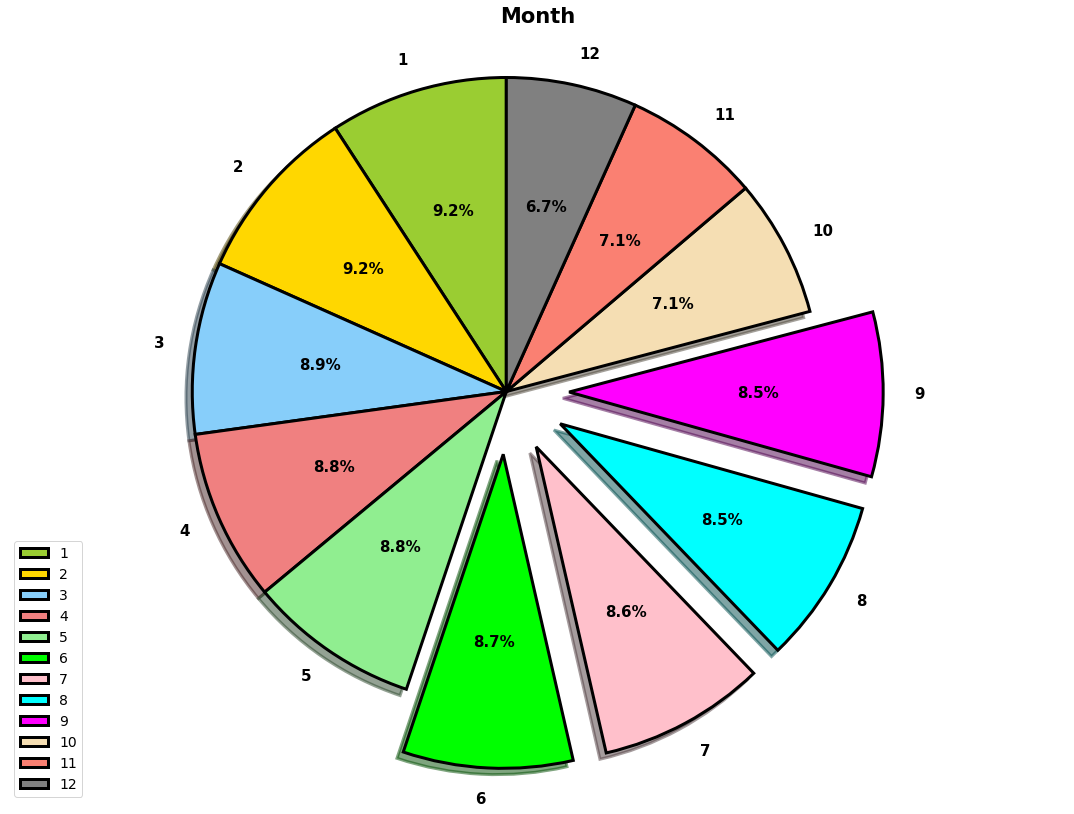

In [15]:
plt.figure(figsize=(19,14))
explode= (0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.0,0.0,0.0)
x1= List_count

##x3= df['QQQ Bearish Quarterly change']
colors =['yellowgreen','gold','lightskyblue','lightcoral','lightgreen', 'lime', 'pink', 'cyan', 'magenta', 'wheat','salmon', "gray"]
plt.pie(x1, labels=new_df_scatter, startangle= 90, explode= explode, colors= colors, autopct= '%1.1f%%',shadow= True, labeldistance= 1.1,
        textprops={'fontweight':'bold','fontsize':15}, wedgeprops={'linewidth':3,'edgecolor':"k"})
plt.legend( loc= 3, fontsize= 14)
plt.title('Month', fontweight="bold",fontsize= 21, pad= 20)
plt.axis('equal')
plt.show()

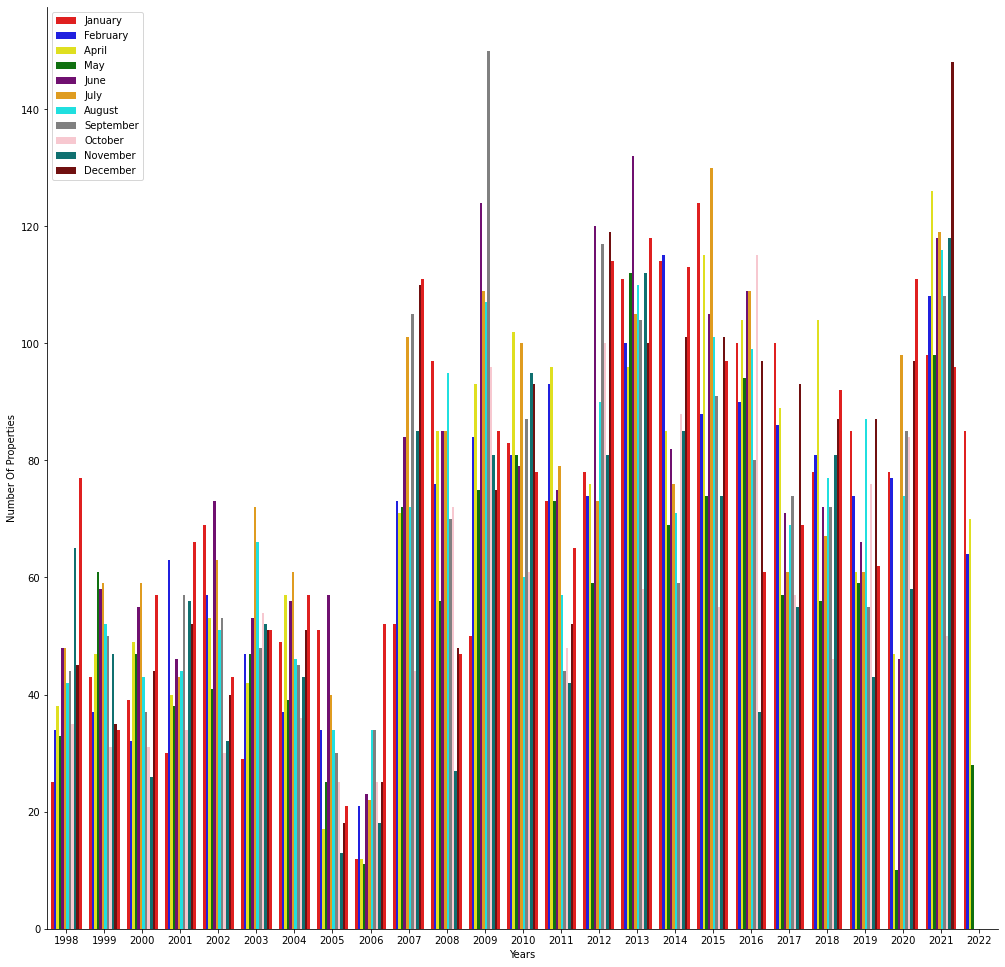

In [16]:
g = sns.catplot(
    x='year',
    data=last_ready_csv,
    kind='count', 
    hue='month',
    palette=["red", "blue", 'yellow', 'green', 'purple', "orange", "cyan" , "gray" , "pink", "Teal", "Maroon" ], 
    height=5, 
    aspect=1.5,
    legend=False,
    ).set_axis_labels('Years', 'Number Of Properties')
g.fig.set_size_inches(15,15)
g.ax.legend(labels=['January','February', 'April ', 'May ', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

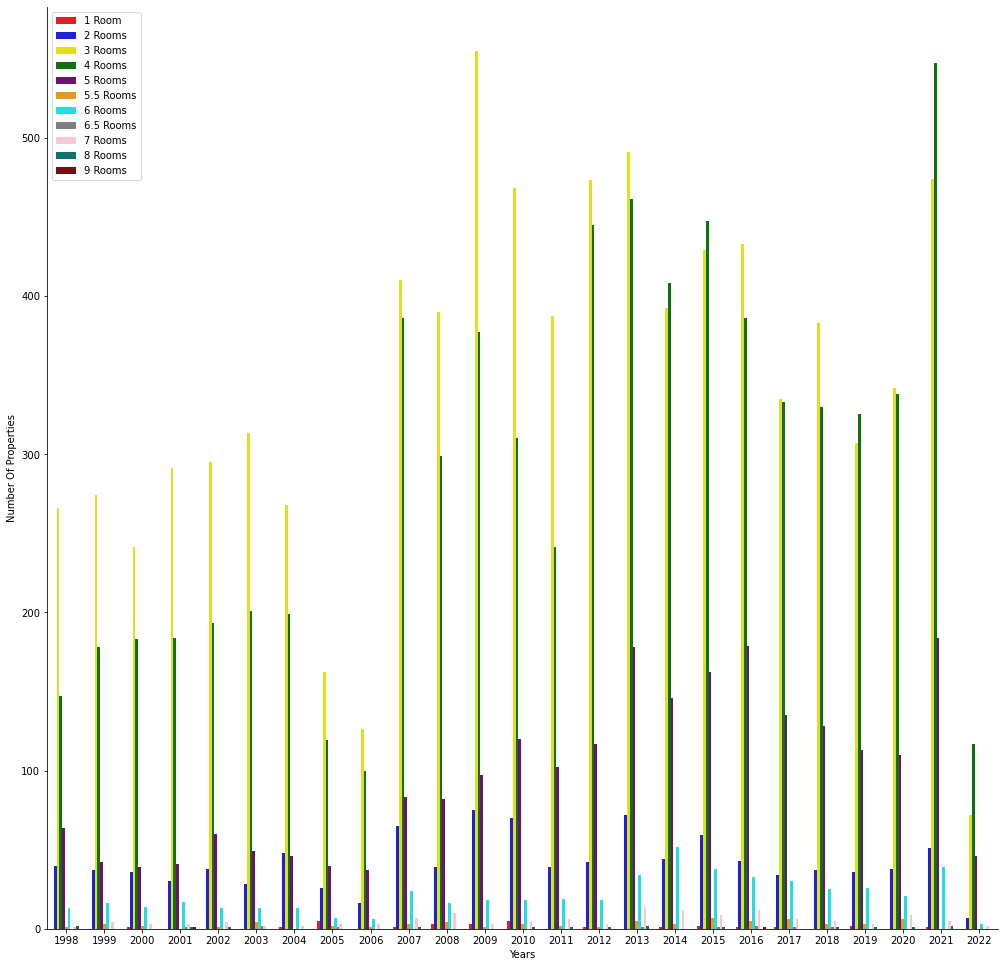

In [17]:
g = sns.catplot(
    x='year',
    data=last_ready_csv,
    kind='count', 
    hue='rooms',
        palette=["red", "blue", 'yellow', 'green', 'purple', "orange", "cyan" , "gray" , "pink", "Teal", "Maroon" ], 
    height=5, 
    aspect=1.5,
    legend=False,
    ).set_axis_labels('Years', 'Number Of Properties')
g.fig.set_size_inches(15,15)
g.ax.legend(labels=['1 Room','2 Rooms', '3 Rooms', '4 Rooms', '5 Rooms',"5.5 Rooms" , "6 Rooms" , "6.5 Rooms" , "7 Rooms" , "8 Rooms" , "9 Rooms"])

In [18]:
last_ready_csv.describe(include = 'all')

propery_type         rooms         floor   square_foot         price  \
count  20065.000000  20065.000000  20065.000000  20065.000000  2.006500e+04   
mean       1.071916      3.665936      3.405582     84.049004  1.254471e+06   
std        0.443320      0.921424      2.685088     30.645253  6.248208e+05   
min        1.000000      1.000000      0.000000     21.500000  8.600000e+04   
25%        1.000000      3.000000      2.000000     64.300000  7.650000e+05   
50%        1.000000      4.000000      3.000000     78.690000  1.180000e+06   
75%        1.000000      4.000000      4.000000     96.860000  1.600000e+06   
max        7.000000      9.000000     24.000000    499.000000  6.000000e+06   

             sector         block      property           day         month  \
count  20065.000000  20065.000000  20065.000000  20065.000000  20065.000000   
mean    4662.843459    279.897932     22.141739     15.715126      6.433491   
std     1056.920211    292.619817     36.700847      8.822410      3.478743   
min     2704.000000      2.000000      0.000000      1.000000      1.000000   
25%     3929.000000     47.000000      6.000000      8.000000      3.000000   
50%     3939.000000    153.000000     12.000000     16.000000      6.000000   
75%     5182.000000    443.000000     25.000000     23.000000      9.000000   
max     7375.000000   1365.000000    636.000000     31.000000     12.000000   

               year           lat           lng  
count  20065.000000  20065.000000  20065.000000  
mean    2011.294642     31.969770     34.794146  
std        6.600092      0.009799      0.018730  
min     1998.000000     31.944642     34.735100  
25%     2007.000000     31.963426     34.780912  
50%     2012.000000     31.968512     34.798290  
75%     2017.000000     31.973463     34.808552  
max     2022.000000     32.068392     34.857651

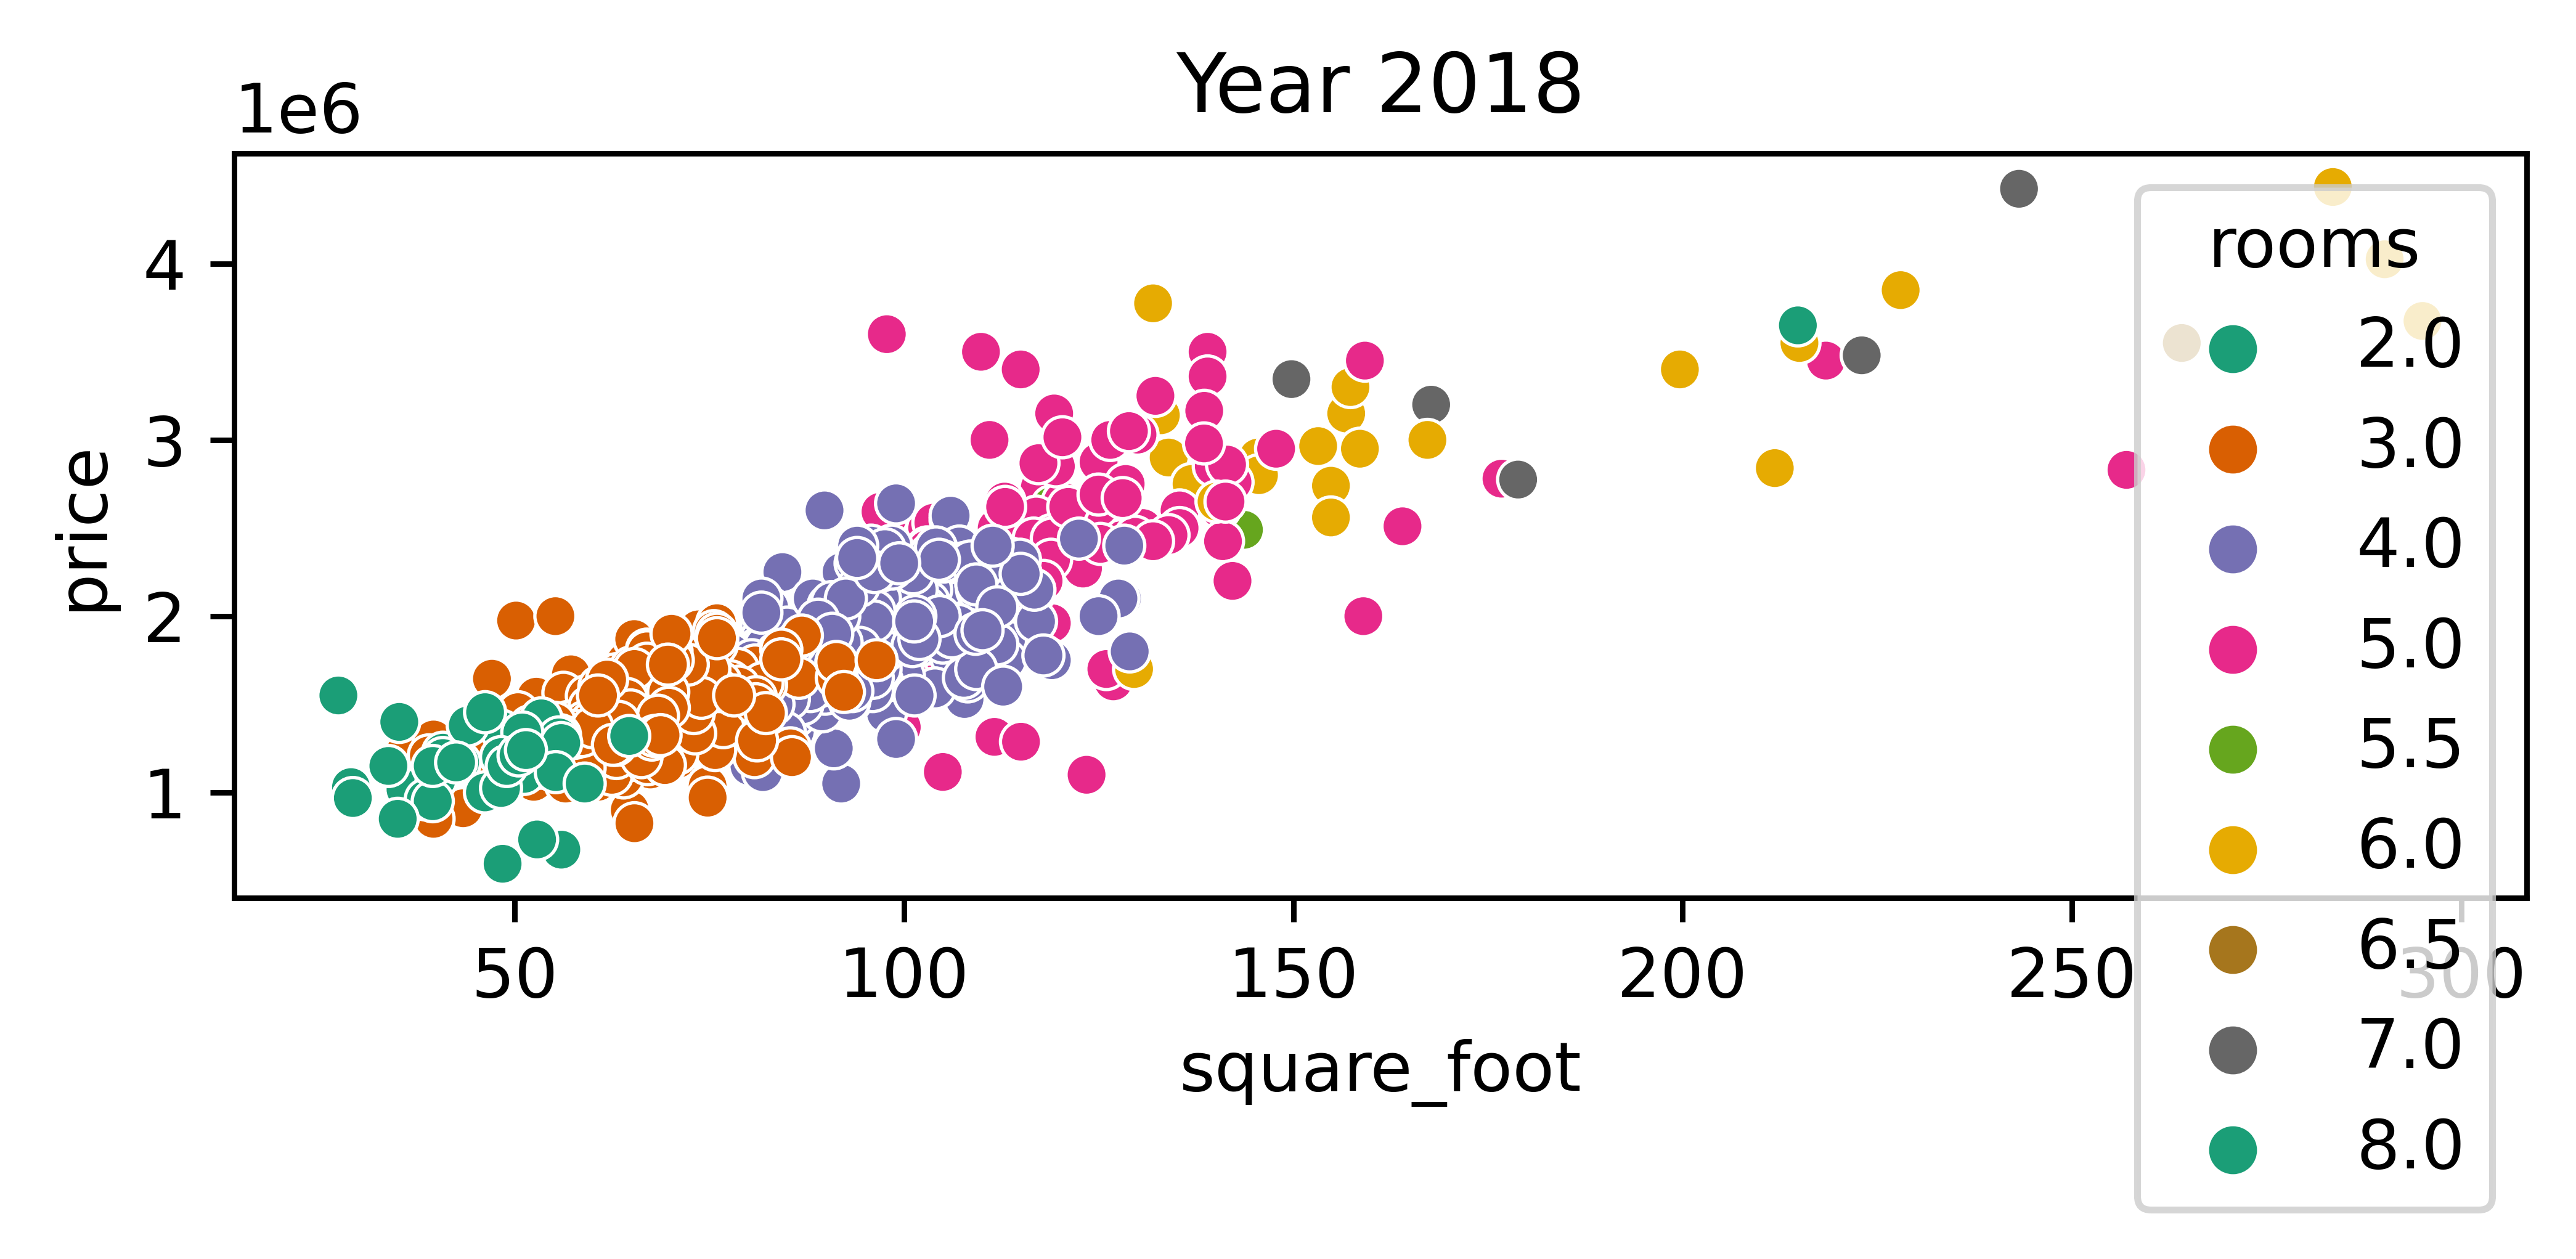

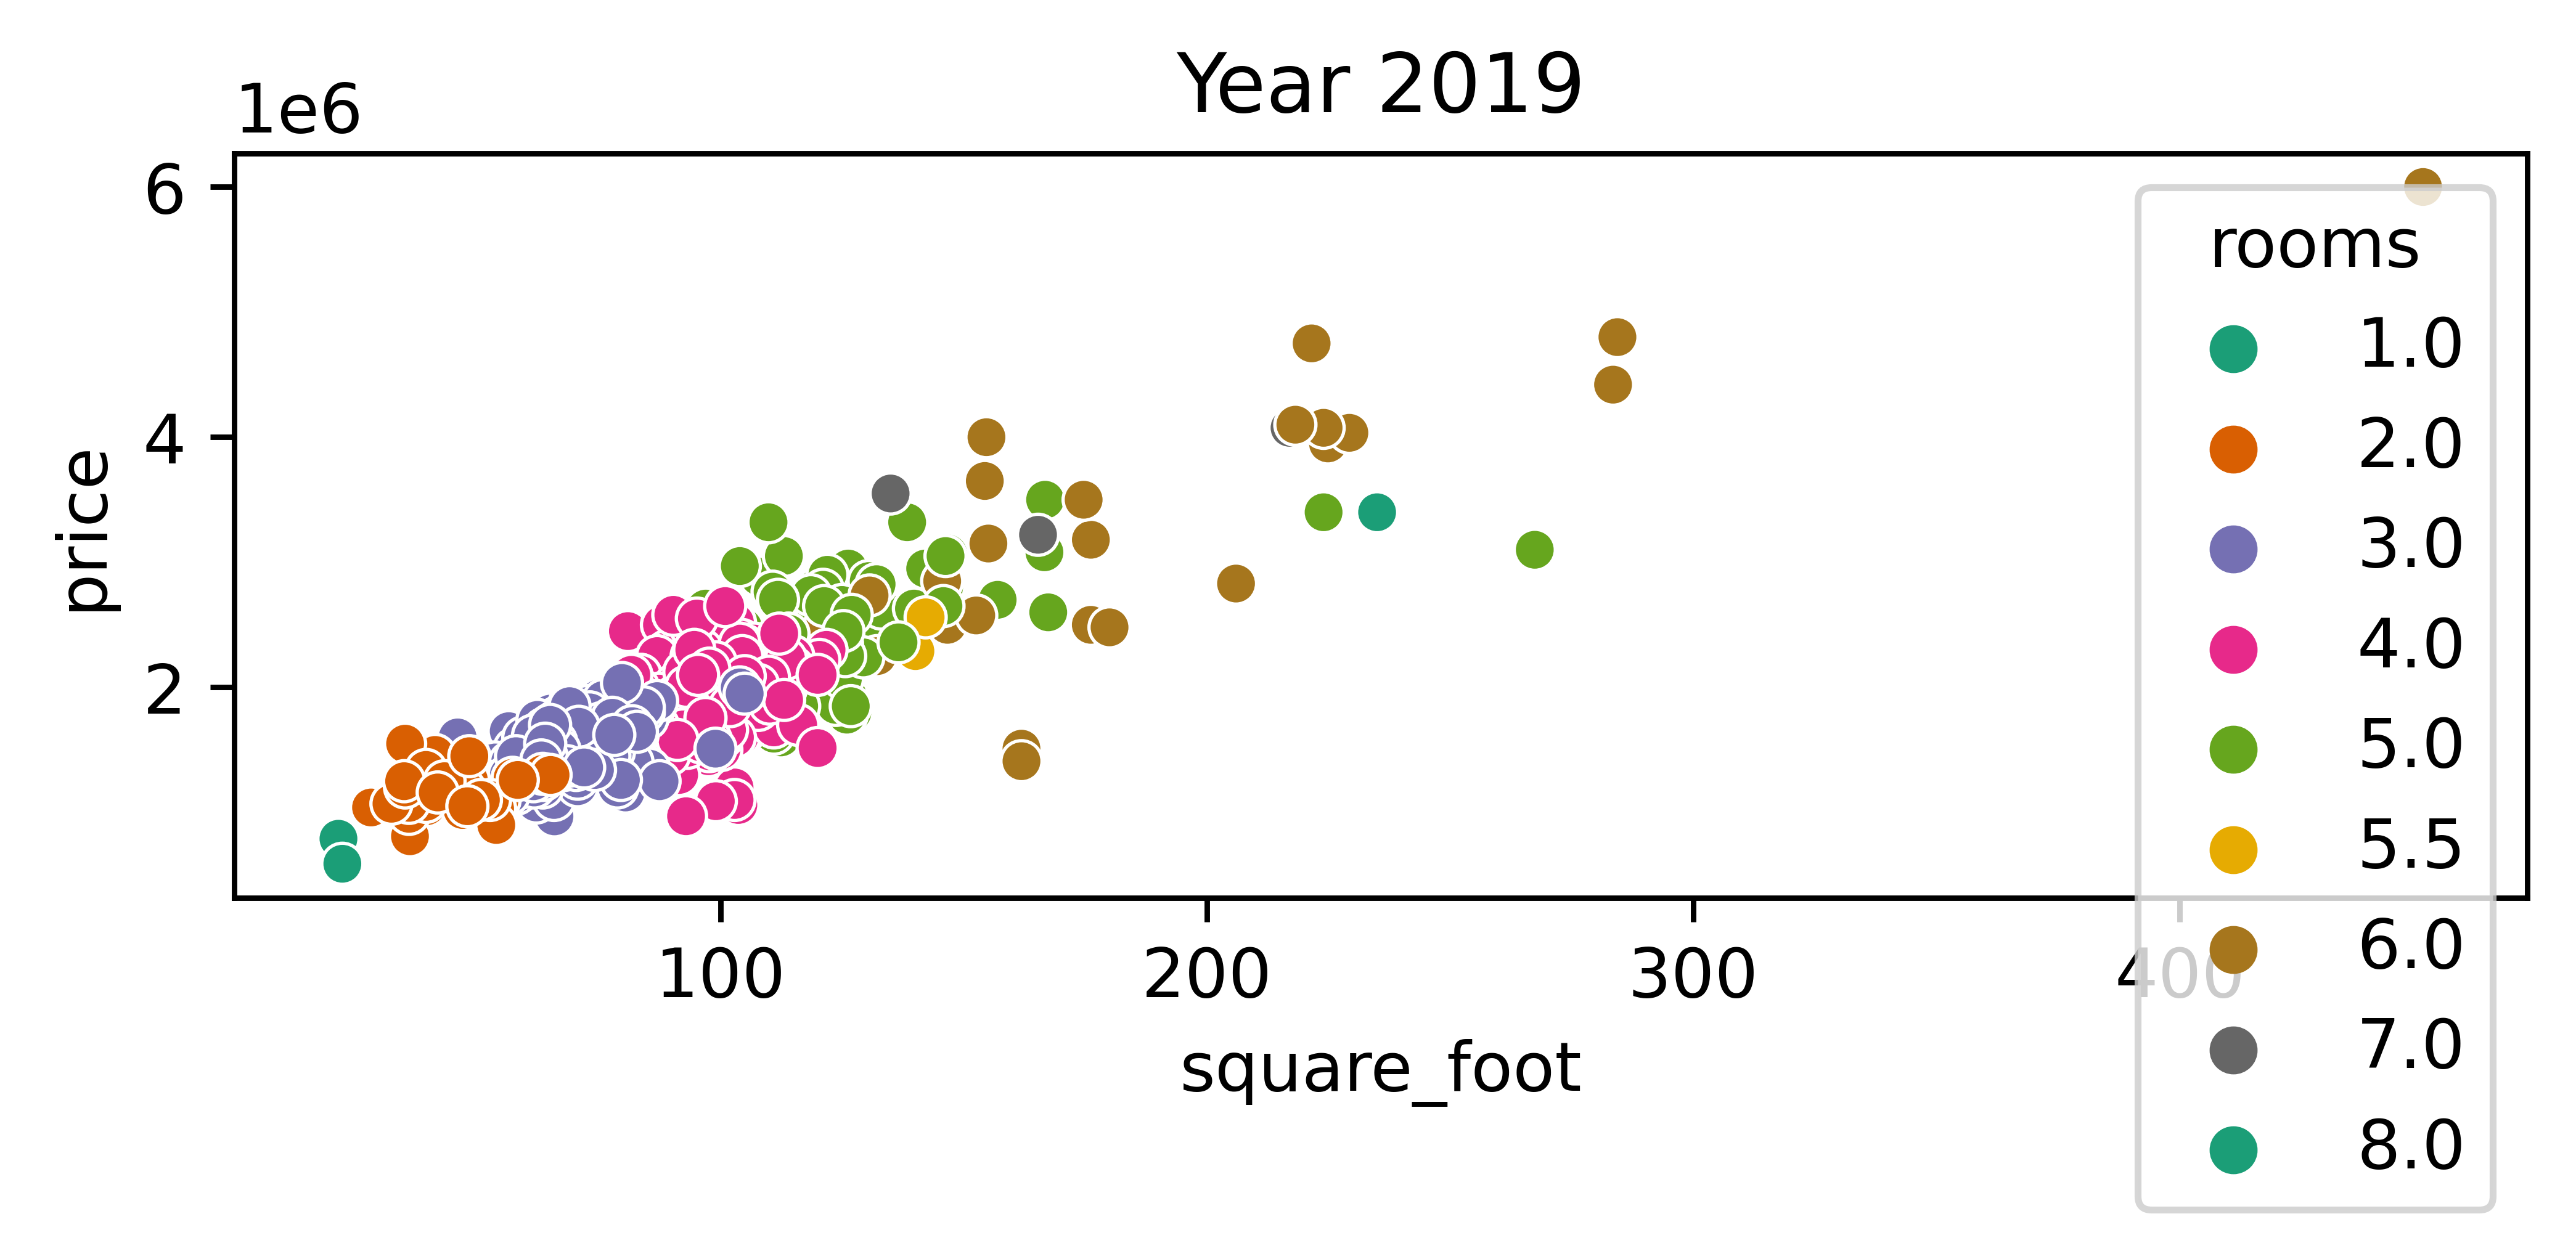

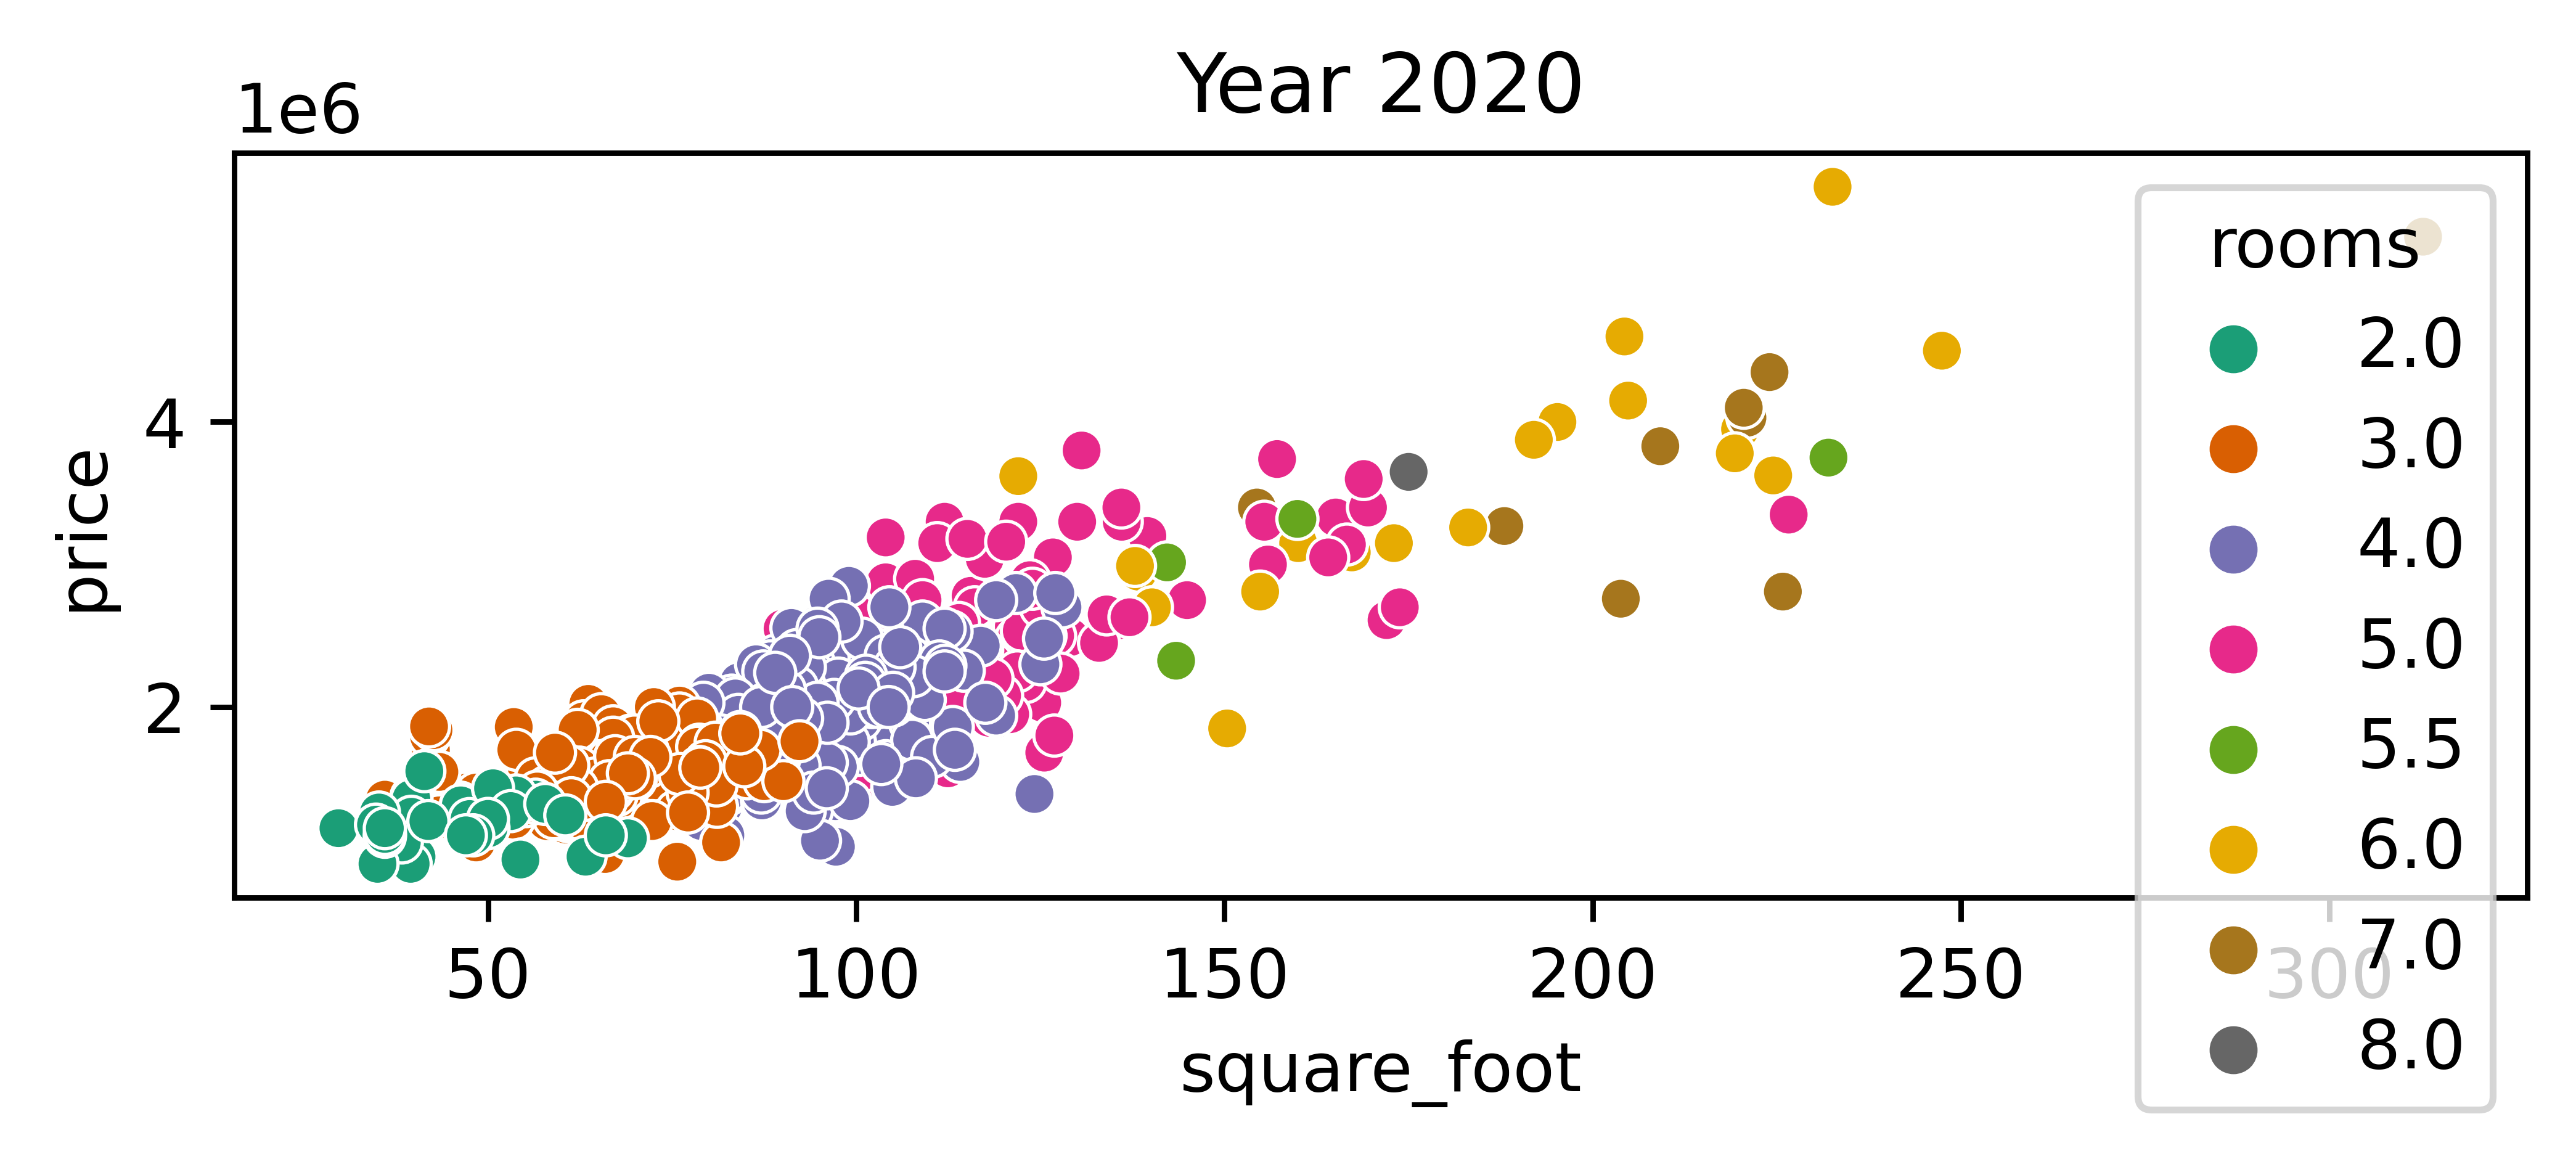

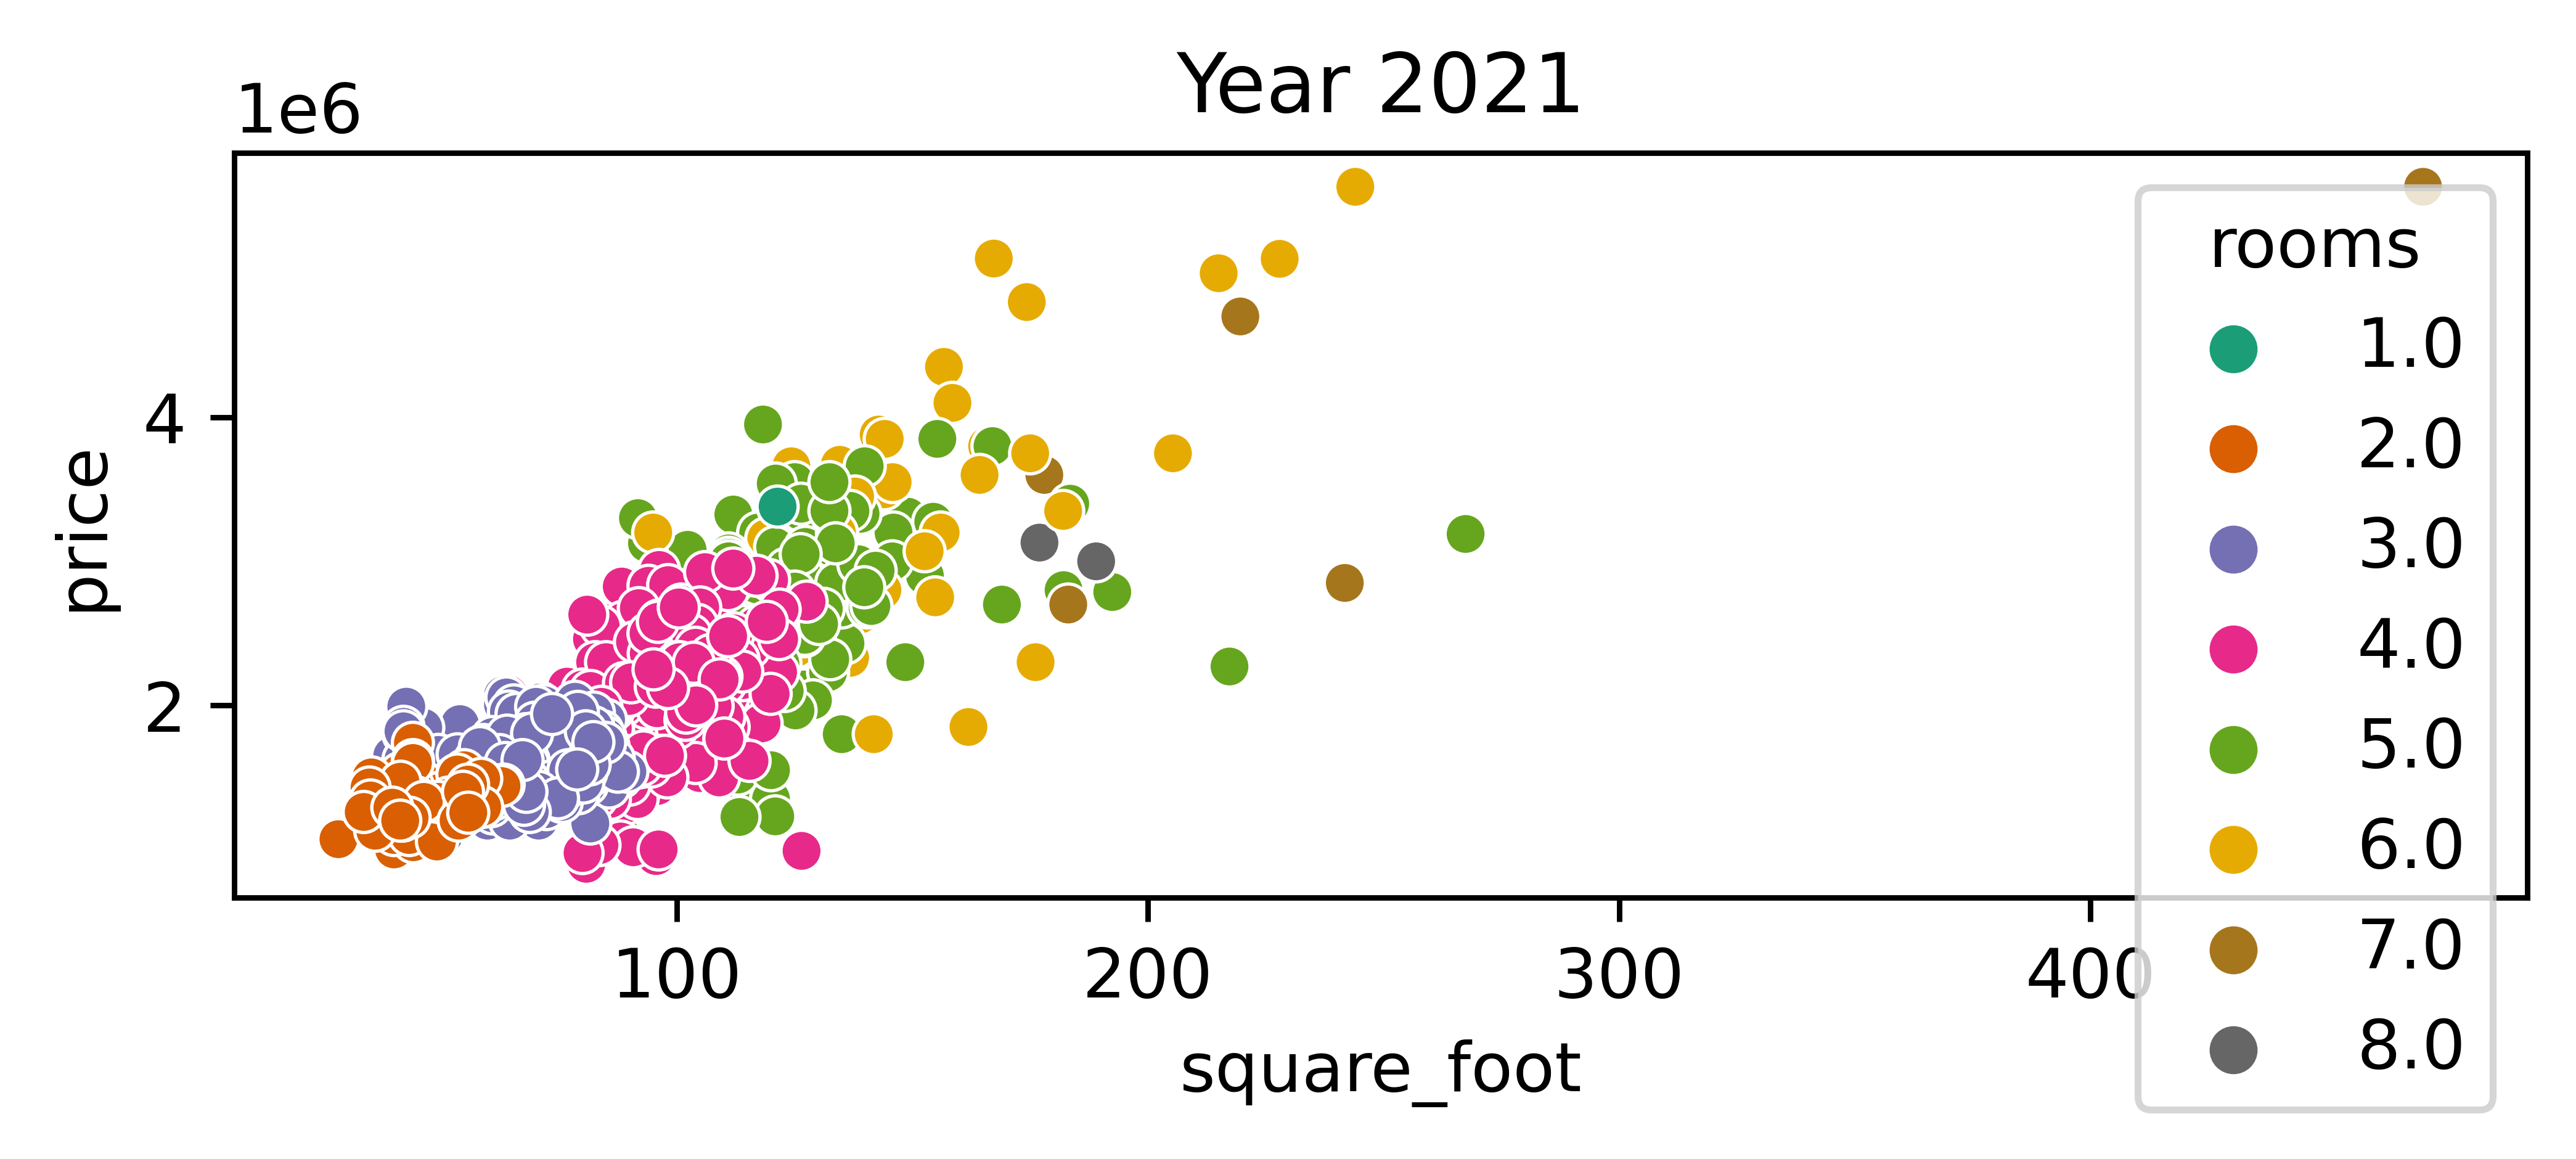

In [19]:
year_data = last_ready_csv["year"].drop_duplicates()
year_data = year_data.sort_values()
room_data = last_ready_csv["rooms"].drop_duplicates()
for i in range(2018,2022):
        data_by_year_and_room = last_ready_csv.loc[(last_ready_csv['year'] == i)]
        plt.figure(figsize=(6,2), dpi = 800)
        sns.scatterplot(x="square_foot", y="price", data=data_by_year_and_room, hue="rooms" , palette="Dark2").set(title=f'Year {i}')


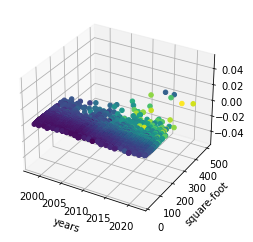

In [20]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')

#data for three-dimensional scattered points
z_data_by_price = last_ready_csv["price"]
x_data_by_year = last_ready_csv["year"]
y_data_by_square = last_ready_csv["square_foot"]

plt.xlabel("years")
plt.ylabel("square-foot")
ax.scatter3D(x_data_by_year, y_data_by_square,c =z_data_by_price, depthshade=False)

# Machine Learning

## implements Machine Learning methods
trying to implement Machine Learning Methods:
* KNN
* Linear Regression



In [122]:
x = last_ready_csv.drop('price', axis=1)
y = last_ready_csv.price

#  Normalization and split to train and test 

In [123]:
x_train, x_test , y_train , y_test = train_test_split(x,y,test_size=0.2,random_state = 0)

In [124]:
print(f"Total number of rows: {len(x)}")
print(f"Total rows of train: {len(x_train)}")
print(f"Total rows of xtest: {len(x_test)}")
print(f"Total rows of ytest: {len(y_test)}")
print(f"Total rows of train: {len(y_train)}")

Total number of rows: 20065
Total rows of train: 16052
Total rows of xtest: 4013
Total rows of ytest: 4013
Total rows of train: 16052


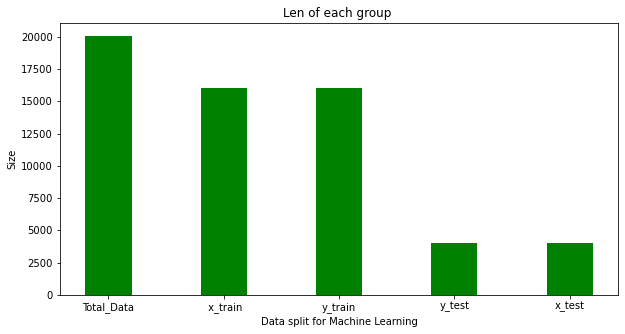

In [125]:
# creating the dataset

numbers = [len(x), len(x_train),len(y_train) , len(y_test) , len(x_test)]
labels = ["Total_Data", " x_train","y_train" , "y_test" , "x_test"]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(labels, numbers, color ='green',
        width = 0.4)
 
plt.xlabel("Data split for Machine Learning")
plt.ylabel("Size")
plt.title("Len of each group ")
plt.show()

In [126]:
#KNN By 7.5% price Error (checked by each vector)


# function to get the distance between 2 vectors.
def euclidean_distance(x1,x2):
    return np.sqrt(np.sum((x1-x2)**2))

# funcation to check 7.5% price error
def boolean_error_price(test_price, train_price):
    if(train_price >= (0.935  * test_price) and  train_price <= (1.075  * test_price)):
        return 1
    return 0
# function to check if the k vectors are matching the test with the error.
def raise_total_count(counter,k_number):
    if(counter == k_number):
        return 1
    return 0

# KNN class.
class KNN:
    def __init__(self, k):
        self.k = k
    
    # getting the X-train and Y-train.
    def fit(self,X,Y,X_TEST,Y_TEST):
        self.X_train = X
        self.Y_train = Y
        self.X_test = X_TEST
        self.Y_test = Y_TEST
        self.total_count_1 = 0
        self.total_count_2 = 0
        self.prediction_1=0
        self.prediction_2=0
        self.counter_1 = 0
        self.first_list = []
        self.second_list = []
        
    # Getting the x-test (4013)
    # sending row to predict if hit
    
    def predict(self, our_x_test):
        for number_of_k in range(1,5):
            self.k = number_of_k
            y_pred = [self._predict(our_x_test[i]) for i in range(len(our_x_test))]
            # Saving the data for the k iteration
            self.first_list.append(self.total_count_1)
            self.second_list.append(self.total_count_2)
            self.total_count_1=0
            self.total_count_2=0
        return np.array(y_pred)
   

    #caculating the distance of our x from test with m of trains. #1
    # get k nearest sample, labels (sort by distance) by locations #2
    # find the prices by location in the Y_train #3
    # getting the location of the test train to provide the price #4
    # getting the price of the test train #5
    # check the price vs the other prices with 7.5% precent diffrence and raise the first counter  #KNN By 7.5% #6
    # check the price vs the other prices (mean) with 7.5% precent diffrence and raise the first counter  #KNN By 7.5% #6
    def _predict(self,x): 
        distances = [euclidean_distance(x,m) for m in self.X_train] #1
        k_indices = np.argsort(distances)[:self.k] # 2
        k_nearest_labels = [self.Y_train[i] for i in k_indices ] #3
        place = np.where(np.all(x==self.X_test,axis=1)) #4 
        price_of_current_x = self.Y_test[place]
        int_price_of_current_x = price_of_current_x[0].item() #5
        sum = 0.0
        for label in k_nearest_labels:
            if(boolean_error_price(int_price_of_current_x,label.item())):
                 self.counter_1 += 1
            sum += label.item()
        self.total_count_1 += raise_total_count(self.counter_1,self.k) #6
        self.counter_1 = 0
        price_by_mean = (sum/self.k)
        self.total_count_2 += boolean_error_price(int_price_of_current_x,price_by_mean) #7
    

# converting dataframe type to 'numpy.ndarray'
final_x_train = x_train.to_numpy()
final_x_test = x_test.to_numpy()
final_y_train = y_train.to_numpy()
final_y_test = y_test.to_numpy()
number_of_k=1


# setting the KNN number.
ctf = KNN(k=number_of_k)
# setting the final x_train and y_train to KNN class
ctf.fit(final_x_train,final_y_train,final_x_test,final_y_test)
ctf.predict(final_x_test)



array([None, None, None, ..., None, None, None], dtype=object)

# Results of KNN (First #1):

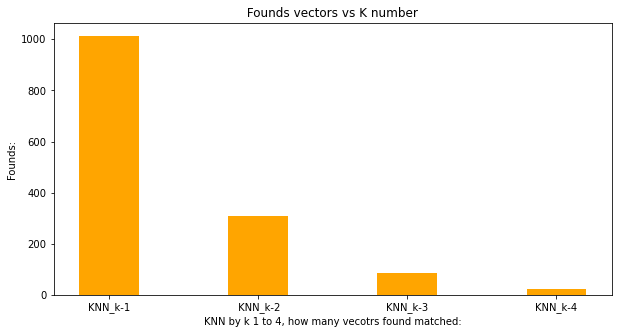

In [127]:
# showing the results of first KNN


labels = ["KNN_k-1", " KNN_k-2","KNN_k-3" , "KNN_k-4"]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(labels, ctf.first_list, color ='orange',
        width = 0.4)
 
plt.xlabel("KNN by k 1 to 4, how many vecotrs found matched:")
plt.ylabel("Founds:")
plt.title(" Founds vectors vs K number ")
plt.show()

# Results of KNN (First #2):

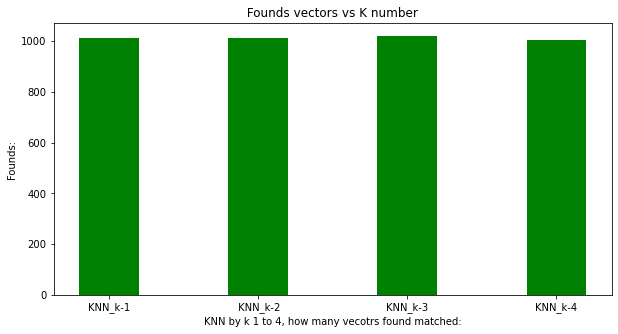

In [128]:
# showing the results of first KNN


labels = ["KNN_k-1", " KNN_k-2","KNN_k-3" , "KNN_k-4"]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(labels, ctf.second_list, color ='green',
        width = 0.4)
 
plt.xlabel("KNN by k 1 to 4, how many vecotrs found matched:")
plt.ylabel("Founds:")
plt.title(" Founds vectors vs K number ")
plt.show()

As we can see results of **KNN #2 by mean** are showing better results,

lets compare with accuracy % between them.

In [129]:
numbers= []
for i,found in enumerate(ctf.first_list):
    numbers.append(ctf.first_list[i] / len(ctf.Y_test))
    numbers.append(ctf.second_list[i]/ len(ctf.Y_test))
numbers

[0.25242960378769,
 0.25242960378769,
 0.07675056067779716,
 0.25292798405183153,
 0.02143035135808622,
 0.25442312484425617,
 0.00548218290555694,
 0.2509344629952654]

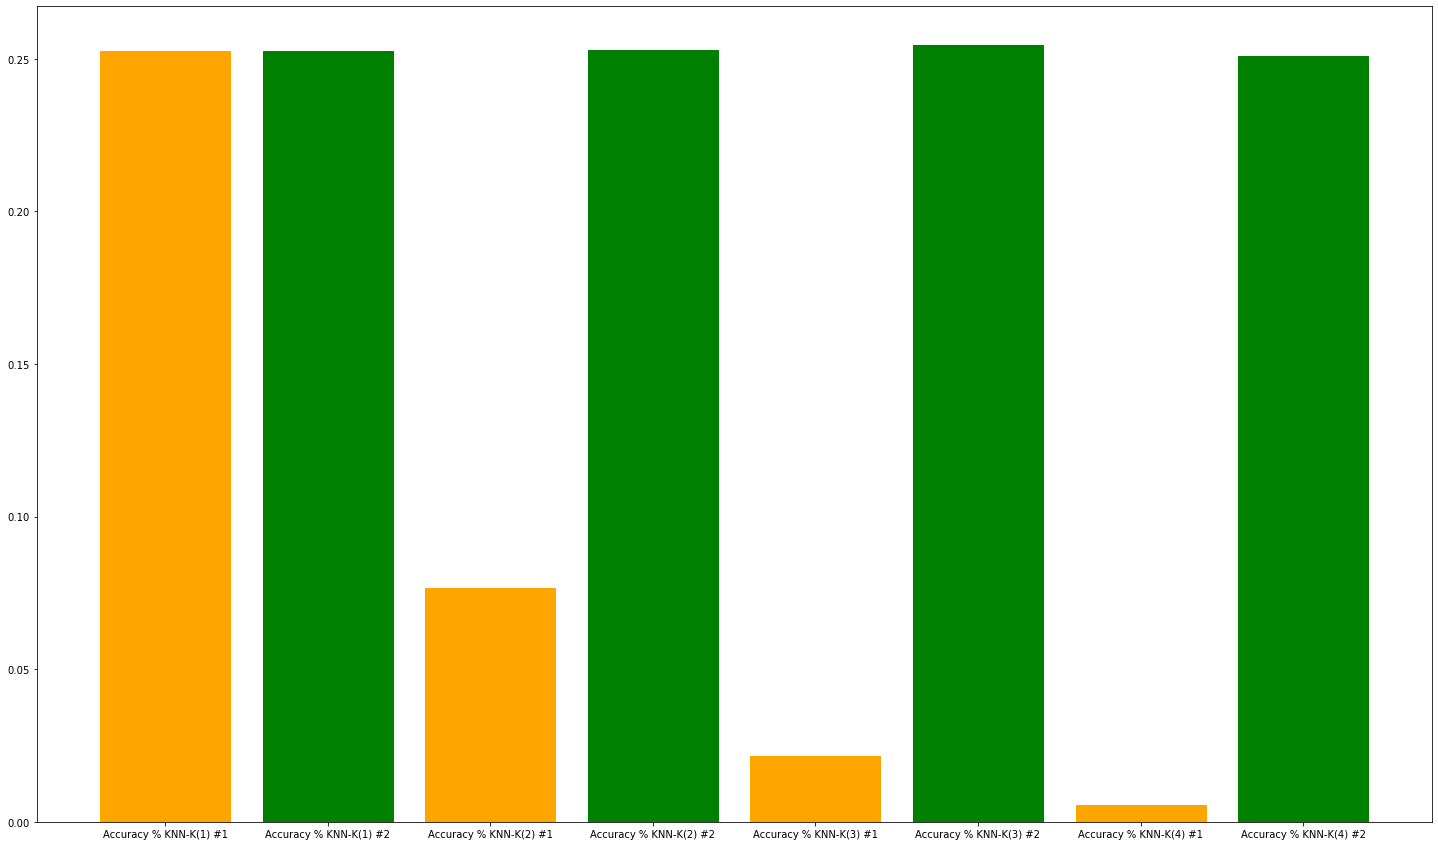

In [130]:
# creating the dataset

labels = ["Accuracy % KNN-K(1) #1", "Accuracy % KNN-K(1) #2",
          "Accuracy % KNN-K(2) #1" , "Accuracy % KNN-K(2) #2",
          "Accuracy % KNN-K(3) #1", "Accuracy % KNN-K(3) #2", 
          "Accuracy % KNN-K(4) #1" , "Accuracy % KNN-K(4) #2"]

plt.figure(figsize=(25,15))

barlist=plt.bar(labels, numbers)
barlist[0].set_color('orange')
barlist[1].set_color('green')
barlist[2].set_color('orange')
barlist[3].set_color('green')
barlist[4].set_color('orange')
barlist[5].set_color('green')
barlist[6].set_color('orange')
barlist[7].set_color('green')
plt.show()
# Define plot space


# Create bar plot




# Forest Random Tree

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from simple_colors import *
regressor = RandomForestRegressor(n_estimators = 100, random_state=0)
regressor.fit(x_train, y_train)
predictedWithoutScaling = regressor.predict(x_test)
from sklearn.metrics import r2_score, mean_squared_error
r2score = r2_score(y_test, predictedWithoutScaling)
mse = mean_squared_error(y_test, predictedWithoutScaling)
print('R2 Score using Random Forest without scaling using mean to fill NA values: ')
print(red(f'{r2score}', ['bold']))
print('Mean Squared Error using Random Forest without scaling using mean to fill NA values: ')
print(red(f'{mse}', ['bold']))

**Predictions** **aren't good** as we all know:

Mean Squared Error: averaged of the squared error of the difference between the actual and predicted values (**lower = better**)  

R2: the correlation between the dependent variable and the set of independent variables (**higher = better**)

As we can see that the model predicted not so good without Scaling, we shall now scale the data using MinMaxScaler.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
regressor.fit(x_train, y_train)
predictedWithScaling = regressor.predict(x_test) 
r2score2 = r2_score(y_test, predictedWithScaling)
mse2 = mean_squared_error(y_test, predictedWithScaling)
print('R2 Score using Random Forest without scaling using mean to fill NA values: ')
print(red(f'{r2score2}', ['bold']))
print('Mean Squared Error using Random Forest without scaling using mean to fill NA values: ')
print(red(f'{mse2}', ['bold']))

**Almost same results**,
We can infer that the **Random Forest Regressor perfroms same, with or without scaling**, So we shall look into another Regressor. Now we shall use **Gradient boosted decision trees**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
boostedRegressor = GradientBoostingRegressor( loss ='ls', learning_rate = 0.1, n_estimators= 200)
boostedRegressor.fit(x_train, y_train)
boostedPredicted = boostedRegressor.predict(x_test)
r2score3 = r2_score(y_test, boostedPredicted)
mse3 = mean_squared_error(y_test, boostedPredicted)
print('R2 Score using Gradient Boosted Forest without scaling using mean to fill NA values: ',r2score3)
print('Mean Squared Error using Gradient Boosted Forest without scaling using mean to fill NA values: ',mse3)

# LinearRegression
* implement Linear Regression and see the Accuracy percentage  

In [131]:
from sklearn.linear_model import LinearRegression
x = last_ready_csv.drop(['price'], axis=1).values
y = last_ready_csv['price'].values
    # spliting the data set into trainging set and test set
    # using sklearn
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)



In [132]:
ml = LinearRegression()
ml.fit(x_train, y_train)
ml.score(x_test,y_test)

0.8365367277516964

In [133]:
y_pred=ml.predict(x_test)

Text(0.5, 1.0, 'Actual vs Predicted')

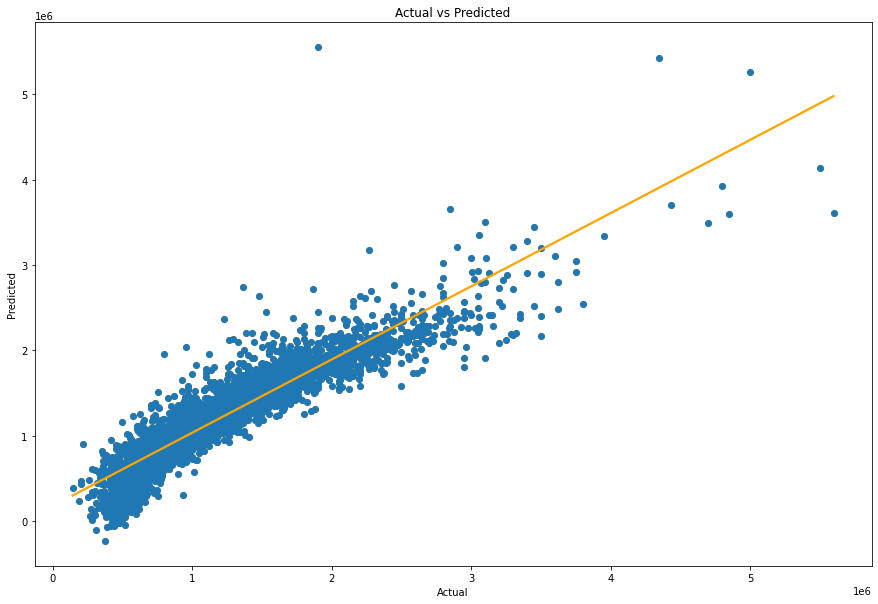

In [134]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
sns.regplot(x=y_test,y=y_pred,ci=None,color ='orange');
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title("Actual vs Predicted")

# Polynomial Features

In [137]:
x = last_ready_csv.drop(['price'], axis=1).values
y = last_ready_csv['price'].values
    # spliting the data set into trainging set and test set
    # using sklearn
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=24)

In [138]:
#applying polynomial regression degree 2
poly = PolynomialFeatures(degree=3, include_bias=True)
x_train_trans = poly.fit_transform(x_train)
x_test_trans = poly.transform(x_test)
#include bias parameter
lr = LinearRegression()
lr.fit(x_train_trans, y_train)
y_pred = lr.predict(x_test_trans)
print(r2_score(y_test, y_pred))


0.8968372542742988


# Conclusion

Our research question is about realestate prices prediction by multiple parameters, derived from a reliable source and documented by govermential institue.

While we examined the data, we found that besides there are lots of other variables that affect the price of an asset, we can actually define a decent approximate price for each asset within our area of data.
Therefore, the more data we collect, the more accurate the price gets including the same set of parameters.

The area we decided to focus on is the city "Rishon Le-Zion" which is big enough for diversed data analysis and also, we familiar with it's price range and realestate standards. We have an option to scrape data from every side of the contry but the experiement was conducted on a reasonable scale.

We managed to execute few machine learning models from modified KNN algorithm to polynomial regression.
Every model we came in contact with, was analized and benchmarked to decide if it's compatible with our expectations.



## Sources
### * Stack Overflow
### * Medium